In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder #import libraries

In [2]:
print(os.listdir("../input/sports-image-classification/dataset/")) #open sports dataset

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']


In [3]:
print(len(os.listdir("../input/sports-image-classification/dataset/train")))
print(len(os.listdir("../input/sports-image-classification/dataset/test"))) #length of training and testing dataset

8227
2056


In [4]:
train = "../input/sports-image-classification/dataset/train"
test = "../input/sports-image-classification/dataset/test"
labels = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
labels_test=pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv') #seperate dataset

In [5]:
labels #labels for it

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


In [6]:
print(labels['label'].value_counts()) #counts of labels

Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: label, dtype: int64


In [7]:
import random #iimport random to get random image set

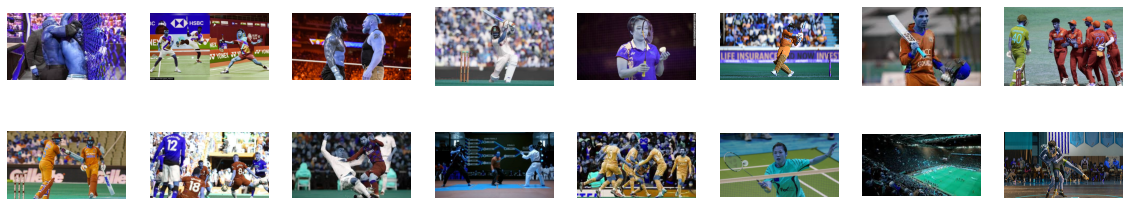

In [8]:
images = random.sample(os.listdir(train), 16)

fig = plt.figure(figsize=(20,4))
for i, im in enumerate(images):
    plt.subplot(2, 8, i+1)
    im = cv2.imread(os.path.join(train, im))
    plt.imshow(im)
    plt.axis('off')
plt.show() #plot images

In [9]:
validation_split = 0.8
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]
print(len(train_labels), len(val_labels)) #train and validation labels

6582 1645


In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, 
                                                             rotation_range=5,
                                                             shear_range=0.2,
                                                             height_shift_range=0.2,
                                                             width_shift_range=0.2,
                                                             vertical_flip=True,
                                                            fill_mode='nearest')
batch_size = 64 #augmenation

2.Modeling by InceptionV3

In [11]:
train_generator = train_datagen.flow_from_dataframe(train_labels,
                                                    directory=train,
                                                    x_col='image_ID',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    target_size=(150,150)) #when data is on secondary storage 

Found 6582 validated image filenames belonging to 7 classes.


In [12]:
val_generator = train_datagen.flow_from_dataframe(val_labels,
                                                  directory=train,
                                                  x_col='image_ID',
                                                  y_col='label', 
                                                  class_mode='categorical',
                                                  batch_size=batch_size,
                                                  target_size=(150,150)) #genearte validation 

Found 1645 validated image filenames belonging to 7 classes.


In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False,weights="imagenet") #apply weights

87924736/87910968 [==============================] - 3s 0us/step


In [14]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [15]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary() #model train

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 24,179,623
Trainable params: 2,377,031
Non-trainable params: 21,802,592
____________________________________

In [16]:
model.compile(optimizer='Adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']) #compile

In [18]:
history = model.fit(
    train_generator,
    validation_data = (val_generator),
    epochs = 20,
    verbose = 1
) #fit the model

Epoch 1/20
103/103 [==============================] - 96s 932ms/step - loss: 0.7034 - accuracy: 0.7530 - val_loss: 0.7102 - val_accuracy: 0.7635
Epoch 2/20
103/103 [==============================] - 96s 931ms/step - loss: 0.6840 - accuracy: 0.7593 - val_loss: 0.8427 - val_accuracy: 0.7058
Epoch 3/20
103/103 [==============================] - 95s 928ms/step - loss: 0.6876 - accuracy: 0.7603 - val_loss: 0.8214 - val_accuracy: 0.7271
Epoch 4/20
103/103 [==============================] - 96s 928ms/step - loss: 0.6559 - accuracy: 0.7680 - val_loss: 0.7735 - val_accuracy: 0.7386
Epoch 5/20
103/103 [==============================] - 96s 935ms/step - loss: 0.6637 - accuracy: 0.7663 - val_loss: 0.8176 - val_accuracy: 0.7271
Epoch 6/20
103/103 [==============================] - 96s 931ms/step - loss: 0.6420 - accuracy: 0.7727 - val_loss: 0.7569 - val_accuracy: 0.7410
Epoch 7/20
103/103 [==============================] - 97s 943ms/step - loss: 0.6595 - accuracy: 0.7694 - val_loss: 0.6996 - val_ac

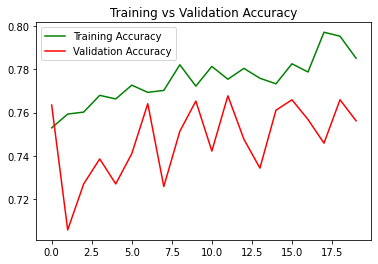

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(train_acc , color = 'green', label = 'Training Accuracy')
plt.plot(val_acc , color = 'red', label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend() #plot for accuracy

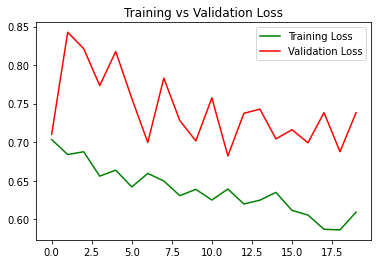

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(train_loss , color = 'green', label = 'Training Loss')
plt.plot(val_loss , color = 'red', label = 'Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend() #plot for loss

In [21]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_dataframe(labels_test,
                                                  directory=test,
                                                  x_col='image_ID',
                                                  class_mode=None,
                                                  batch_size=batch_size,
                                                  target_size=(150,150))
img=pd.DataFrame(model.predict(test_generator))
img #image file been classified

Found 2056 validated image filenames.


,0,1,2,3,4,5,6
0,0.000205,0.018274,0.971545,0.008403,6.122015e-06,0.001536,0.000030
1,0.000907,0.000636,0.000020,0.012474,2.181683e-03,0.959355,0.024427
2,0.921002,0.000013,0.000145,0.000202,7.856562e-09,0.078381,0.000256
3,0.226858,0.000068,0.001506,0.001095,3.180875e-08,0.770214,0.000258
4,0.238585,0.542796,0.008834,0.130967,6.184575e-04,0.022770,0.055430
...,...,...,...,...,...,...,...
2051,0.140377,0.037081,0.003826,0.286314,3.200613e-03,0.144319,0.384883
2052,0.113084,0.008949,0.000091,0.046132,2.535745e-05,0.825374,0.006345
2053,0.190092,0.489766,0.000383,0.167185,4.758553e-06,0.143609,0.008961
2054,0.001473,0.000425,0.000323,0.002498,1.419548e-02,0.038468,0.942617
